# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [1]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
components = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())
absorbing = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

In [3]:
def random_walk(G, iterations):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0:
            n = np.random.choice(neighbours)
        
    return pages_count

In [4]:
def print_page_counts(counts):
    for i in range(len(counts)):
        print(i, ':', counts[i])

In [5]:
iterations = 1000

print_page_counts(random_walk(components, iterations))

0 : 284.0
1 : 283.0
2 : 284.0
3 : 149.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0


In [6]:
print_page_counts(random_walk(absorbing, iterations))

0 : 0.0
1 : 999.0
2 : 0.0
3 : 0.0
4 : 1.0


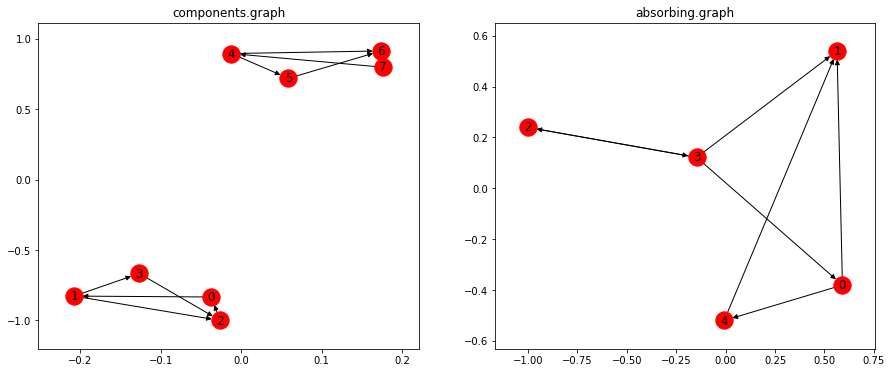

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("components.graph")
nx.draw_networkx(components, arrows=True)

plt.subplot(1,2,2)
plt.title("absorbing.graph")
nx.draw_networkx(absorbing, arrows=True)

### Explanation
The components graph has two separate connected components. Therefore the random surfer will never leave the component that it randomly selected at the start.<br>
The absorbing graph has (as its name says) an absorbing node (node 1). Once the random surfer reaches this node, it will never leave it again.

#### Exercise 2.13

In [8]:
def random_walk_teleportation(G, iterations, teleportation_prob=.15):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0 and np.random.rand(1) > teleportation_prob:
            n = np.random.choice(neighbours)
        else:
            n = np.random.choice(G.nodes())
        
    return pages_count

In [9]:
print_page_counts(random_walk_teleportation(components, iterations))

0 : 142.0
1 : 137.0
2 : 146.0
3 : 82.0
4 : 136.0
5 : 79.0
6 : 139.0
7 : 139.0


In [10]:
print_page_counts(random_walk_teleportation(absorbing, iterations))

0 : 146.0
1 : 349.0
2 : 140.0
3 : 210.0
4 : 155.0


---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [11]:
wiki = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())
titles= []
with open('../data/wikipedia_titles.tsv') as tsvfile:
    titles = list(csv.reader(tsvfile, delimiter='\t'))[1:]

In [12]:
def H(graph):
    H = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
    edges = list(graph.edges)
    for u,v in edges:
        H[int(u)][int(v)] = 1 / len(list(graph.neighbors(u)))
    
    return H

In [21]:
def w(graph):
    nodes = list(graph.nodes)
    return np.array(list(map(lambda n : len(list(graph.neighbors(n))) < 1, nodes)))

In [22]:
def G(graph, damping=.15):
    N = graph.number_of_nodes()
    H_caret = H(graph) + np.ones((N, N)) * w(graph)[..., np.newaxis] / N
    return (1-damping) * H_caret + damping * np.ones((N, N)) / N

In [23]:
def power_iteration(G, iterations):
    N = G.shape[1]
    pi = np.ones(N) / N
    
    for i in range(iterations):
        pi = np.dot(pi, G)
        pi /= np.linalg.norm(pi)
    
    return pi

In [24]:
page_rank = power_iteration(G(wiki), 10000)

In [25]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', page_rank[index], titles[index][1])

1 : 0.27279358941096604 United States
2 : 0.18888184990628068 United Kingdom
3 : 0.18236001738316576 France
4 : 0.16345943081235037 Europe
5 : 0.1445235008209256 Germany
6 : 0.14045857734955056 England
7 : 0.1357361327454811 World War II
8 : 0.13158790015144317 Latin
9 : 0.13104401317611136 India
10 : 0.12325766254084093 English language


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [28]:
def find_index_of_title(title):
    for t in titles:
        if t[1] == title:
            return int(t[0])
    return -1

hist_math_index = find_index_of_title('History of mathematics')
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 2530


In [30]:
wiki_gamed = wiki.copy()
for i in range(300):
    wiki_gamed.add_edge(ranks[i], hist_math_index)

In [ ]:
page_rank = power_iteration(G(wiki_gamed), 12000)

In [ ]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', page_rank[index], titles[index][1])

In [34]:
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 1


In [35]:
import operator

# Verify with networx implementation
pr = nx.pagerank(wiki_gamed)

sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
for i in range(10):
    index = int(sorted_pr[i][0])
    print(i+1, ':', sorted_pr[index], titles[index][1])

1 : (5276, 2.6720145711872518e-05) United States
2 : ('4566', 0.00010089696144127183) History of mathematics
3 : (3334, 2.6720145711872518e-05) United Kingdom
4 : ('2182', 0.0001294841019906659) France
5 : ('2293', 0.00014069644347584098) Europe
6 : ('2368', 0.00012028805322154915) Germany
7 : ('570', 0.00014758922583199639) England
8 : ('4900', 2.6720145711872518e-05) World War II
9 : ('342', 7.5387270437825e-05) Latin
10 : ('3389', 9.240422547897463e-05) India


In [27]:
hist_math_rank = int(np.where(sorted_pr==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

TypeError: only size-1 arrays can be converted to Python scalars